In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = '16'
plt.rcParams['ytick.labelsize'] = '16'
plt.rcParams['axes.labelsize'] = '18'
plt.rcParams['axes.titlesize'] = '18'

nba_team_stats = pd.read_csv('2023-2024_nba_team_stats_per_game.csv')
nba_season_stats = pd.read_csv('2023-2024_season_stats.csv')

# Bringing it all together

Over the last few weeks, we have spent a lot of time learning how to read in datasets, make hypotheses, and test them with the data. Today, we're going to go through and review everything that we have covered, using the NBA 2023-2024 season team stats. I have two dataframes, one of which is a bunch of "per game" stats for every team, and another which is the end of the season standings. Let's take a look at these:

In [5]:
nba_team_stats

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Indiana Pacers,82,240.3,47.0,92.7,0.507,13.2,35.3,0.374,...,0.782,10.1,31.4,41.5,30.8,7.7,5.9,12.9,21.4,123.3
1,2,Boston Celtics,82,241.8,43.9,90.2,0.487,16.5,42.5,0.388,...,0.807,10.7,35.6,46.3,26.9,6.8,6.6,11.9,16.2,120.6
2,3,Oklahoma City Thunder,82,241.5,44.5,89.3,0.499,13.3,34.2,0.389,...,0.825,8.8,33.2,42.0,27.1,8.5,6.6,12.7,18.8,120.1
3,4,Milwaukee Bucks,82,241.5,43.1,88.5,0.487,14.2,38.1,0.373,...,0.774,9.4,34.8,44.2,26.5,6.8,5.0,12.9,19.2,119.0
4,5,Atlanta Hawks,82,242.1,43.0,92.5,0.465,13.7,37.7,0.364,...,0.797,12.5,32.2,44.7,26.6,7.5,4.5,13.5,18.6,118.3
5,6,Los Angeles Lakers,82,242.1,43.7,87.5,0.499,11.8,31.4,0.377,...,0.782,8.2,34.9,43.1,28.5,7.4,5.5,14.0,15.6,118.0
6,7,Dallas Mavericks,82,240.3,43.1,89.7,0.481,14.6,39.5,0.369,...,0.758,9.7,33.2,42.9,25.7,6.9,5.0,12.5,18.3,117.9
7,8,Golden State Warriors,82,241.8,43.7,91.6,0.477,14.8,38.9,0.380,...,0.780,12.1,34.6,46.7,29.3,7.0,4.6,14.3,19.5,117.8
8,9,Sacramento Kings,82,242.1,43.3,90.9,0.477,14.4,39.3,0.366,...,0.745,10.8,33.2,44.0,28.3,7.6,4.2,13.1,19.9,116.6
9,10,Phoenix Suns,82,241.2,42.5,86.1,0.493,12.4,32.6,0.382,...,0.808,10.1,33.9,44.1,27.0,7.4,6.0,14.9,18.0,116.2


In [4]:
nba_season_stats

,Team,W,L,W/L%,PS/G,PA/G,SRS
0,Boston Celtics,64,18,0.780,120.6,109.2,10.75
1,New York Knicks,50,32,0.610,112.8,108.2,4.36
2,Milwaukee Bucks,49,33,0.598,119.0,116.4,2.44
3,Cleveland Cavaliers,48,34,0.585,112.6,110.2,1.98
4,Orlando Magic,47,35,0.573,110.5,108.4,1.48
5,Indiana Pacers,47,35,0.573,123.3,120.2,2.75
6,Philadelphia 76ers,47,35,0.573,114.6,111.5,2.51
7,Miami Heat,46,36,0.561,110.1,108.4,1.10
8,Chicago Bulls,39,43,0.476,112.3,113.7,-1.77
9,Atlanta Hawks,36,46,0.439,118.3,120.5,-2.38


At the end of the day, wins are the most important stat that we care about--we want the fans to get to see their team winning, and we're going to investigate how different team stats correlated with wins. But the stats we care about are in one dataframe, and the wins are in another dataframe. In order to compare these, we need to combine these data products. The way that we can do this is with a function in pandas called "merge". To merge two dataframes, you give the function the two data frames you care about and tell it which column you would like it to combine on. In this case, we want to match on the "Team" column. Let's see below how this works:

In [6]:
nba_all = pd.merge(nba_team_stats, nba_season_stats, on='Team')

nba_all

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,BLK,TOV,PF,PTS,W,L,W/L%,PS/G,PA/G,SRS
0,1,Indiana Pacers,82,240.3,47.0,92.7,0.507,13.2,35.3,0.374,...,5.9,12.9,21.4,123.3,47,35,0.573,123.3,120.2,2.75
1,2,Boston Celtics,82,241.8,43.9,90.2,0.487,16.5,42.5,0.388,...,6.6,11.9,16.2,120.6,64,18,0.780,120.6,109.2,10.75
2,3,Oklahoma City Thunder,82,241.5,44.5,89.3,0.499,13.3,34.2,0.389,...,6.6,12.7,18.8,120.1,57,25,0.695,120.1,112.7,7.36
3,4,Milwaukee Bucks,82,241.5,43.1,88.5,0.487,14.2,38.1,0.373,...,5.0,12.9,19.2,119.0,49,33,0.598,119.0,116.4,2.44
4,5,Atlanta Hawks,82,242.1,43.0,92.5,0.465,13.7,37.7,0.364,...,4.5,13.5,18.6,118.3,36,46,0.439,118.3,120.5,-2.38
5,6,Los Angeles Lakers,82,242.1,43.7,87.5,0.499,11.8,31.4,0.377,...,5.5,14.0,15.6,118.0,47,35,0.573,118.0,117.4,1.07
6,7,Dallas Mavericks,82,240.3,43.1,89.7,0.481,14.6,39.5,0.369,...,5.0,12.5,18.3,117.9,50,32,0.610,117.9,115.6,2.30
7,8,Golden State Warriors,82,241.8,43.7,91.6,0.477,14.8,38.9,0.380,...,4.6,14.3,19.5,117.8,46,36,0.561,117.8,115.2,2.77
8,9,Sacramento Kings,82,242.1,43.3,90.9,0.477,14.4,39.3,0.366,...,4.2,13.1,19.9,116.6,46,36,0.561,116.6,114.8,2.29
9,10,Phoenix Suns,82,241.2,42.5,86.1,0.493,12.4,32.6,0.382,...,6.0,14.9,18.0,116.2,49,33,0.598,116.2,113.2,3.08


In [7]:
nba_all.columns.values

array(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'W', 'L', 'W/L%', 'PS/G', 'PA/G',
       'SRS'], dtype=object)

Now, we have a dataframe that contains a ton of info about all the team stats per game. Let's ask the question: which stat is the most correlated with winning, and which is the least? To do this, let's use the scipy "linregress" function. First, before we systematically test this for everything, do we have a guess for what the answer is? Let's test that below to remind ourselves how to measure the correlation coefficient and the slope.

In [16]:
from scipy.stats import linregress

column_to_test = 'PTS'

fit = linregress(nba_all[column_to_test], nba_all['W'])

fit

LinregressResult(slope=1.9293039344162366, intercept=-179.36509538902254, rvalue=0.6120893444902137, pvalue=0.0003248926449969269, stderr=0.47105023359990655, intercept_stderr=53.83943167093214)

And now, let's plot this, along with the best fitting line.

Text(0, 0.5, 'Wins')

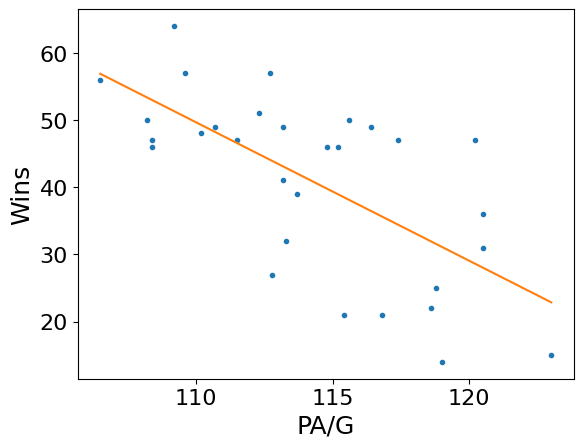

In [15]:
slope = fit.slope
intercept = fit.intercept

x_arr = np.linspace(np.min(nba_all[column_to_test]), np.max(nba_all[column_to_test]), 100)
wins_arr = slope * x_arr + intercept

plt.plot(nba_all[column_to_test], nba_all['W'], '.')
plt.plot(x_arr, wins_arr)
plt.xlabel(column_to_test)
plt.ylabel('Wins')

Our "fit" object also contains the spearman r value, which is our best measure of how correlated two variables are. Let's measure that below:

In [13]:
rvalue = fit.rvalue

print('Spearman r:', rvalue)
print('Spearman r^2', rvalue**2)

Spearman r: 0.6120893444902137
Spearman r^2 0.37465336563845947


But how can we find out if this is the strongest correlation that exists in our data? We could go through individually and check every single column, but that would be really slow. We can instead employ a loop. Let's take a look at the full list of columns that we want to test. What we can do is do a "for" loop where we loop through each of those columns, and do whatever we want to that value. For a quick example, let's loop through and print the average value of every column we care about, in addition to the standard deviation. 

In [17]:
columns_to_test = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
                   '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
                   'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PA/G']

for column in columns_to_test:
    print(column, np.mean(nba_all[column]), np.std(nba_all[column]))

FG 42.17666666666667 1.6891187709045872
FGA 88.90333333333332 2.038706016624816
FG% 0.4743 0.016627587517937366
3P 12.840000000000002 1.1971076253481414
3PA 35.106666666666676 2.8321880038035765
3P% 0.3656666666666667 0.013796940079436304
2P 29.33666666666666 1.6436713648280041
2PA 53.796666666666674 2.4666418917674733
2P% 0.5453333333333333 0.021158659902954353
FT 17.026666666666667 1.345841331245585
FTA 21.723333333333333 1.4788922280620123
FT% 0.7839666666666667 0.02330448216307087
ORB 10.543333333333333 1.1339263154583232
DRB 32.986666666666665 1.2194898751344991
TRB 43.54666666666665 1.4349758031254591
AST 26.673333333333332 1.823537465721198
STL 7.4766666666666675 0.5457003654835582
BLK 5.146666666666666 0.7813378839457926
TOV 13.596666666666668 1.0425875929095305
PF 18.733333333333338 1.2869429755129878
PTS 114.22 4.183332005311874
PA/G 114.20333333333335 4.235286950792774


Let's try this again but make it a bit cleaner--to do this, we can use the python "round" function to only get a few significant digits for each of these numbers.

In [18]:
for column in columns_to_test:
    print(column, round(np.mean(nba_all[column]),2), round(np.std(nba_all[column]),2))

FG 42.18 1.69
FGA 88.9 2.04
FG% 0.47 0.02
3P 12.84 1.2
3PA 35.11 2.83
3P% 0.37 0.01
2P 29.34 1.64
2PA 53.8 2.47
2P% 0.55 0.02
FT 17.03 1.35
FTA 21.72 1.48
FT% 0.78 0.02
ORB 10.54 1.13
DRB 32.99 1.22
TRB 43.55 1.43
AST 26.67 1.82
STL 7.48 0.55
BLK 5.15 0.78
TOV 13.6 1.04
PF 18.73 1.29
PTS 114.22 4.18
PA/G 114.2 4.24


Looping through data is one of the easiest ways to make measurements for a bunch of different variables that you care about. We can do this again, where this time, we measure the spearman r value for every single statistic that we want to compare to wins. We can even go a step further. Let's loop through, plot every single correlation (with a best fitting line), and save the best fitting r value for every single value. If we want to save values from a loop, a good way to do this is to "append" those values to a list every time we move through the loop. We can see how that works below as we loop through.

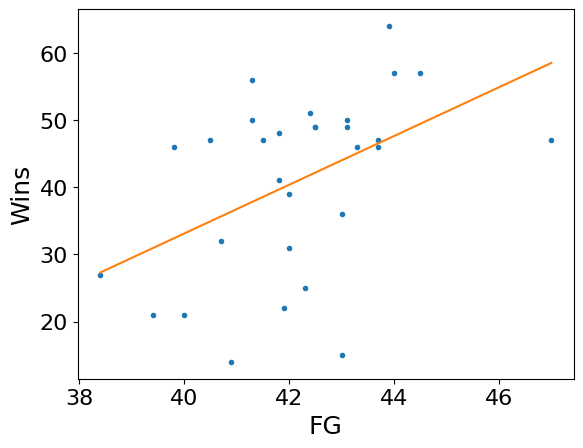

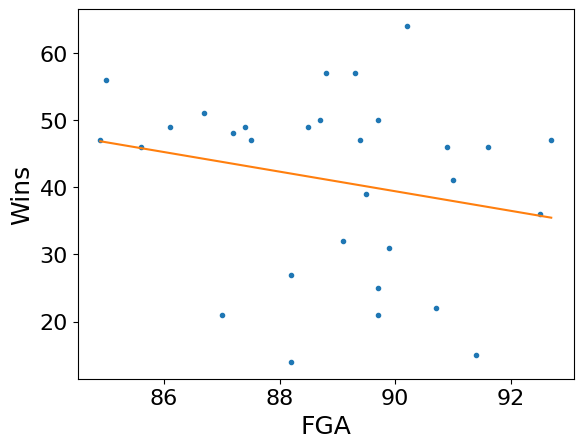

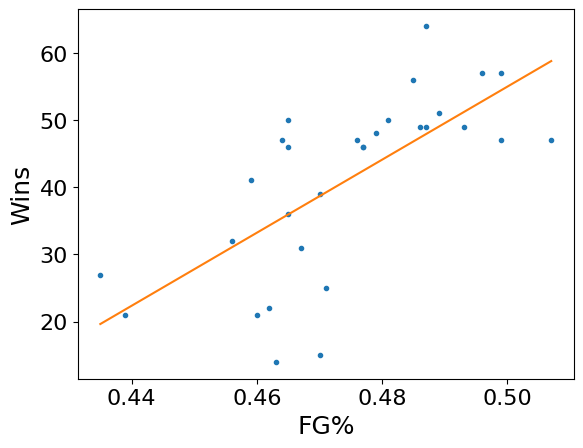

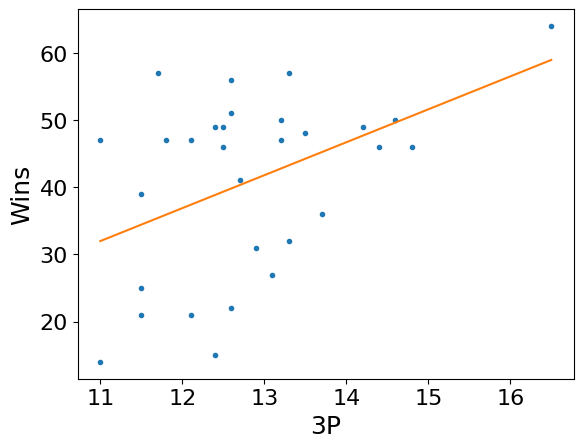

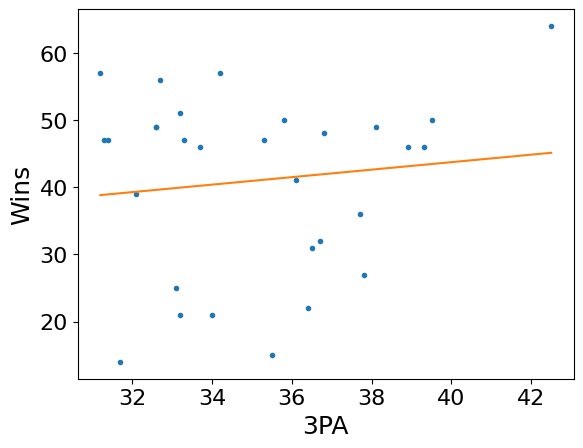

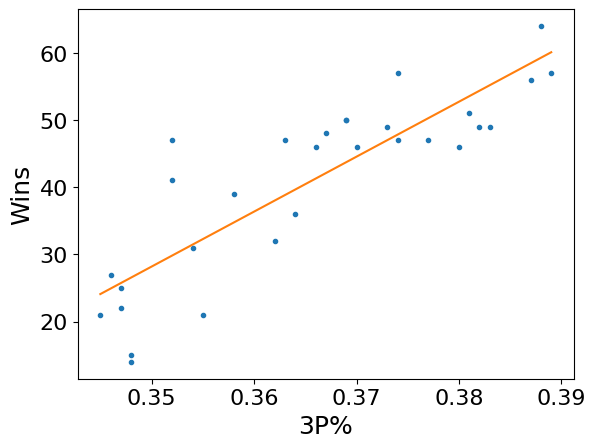

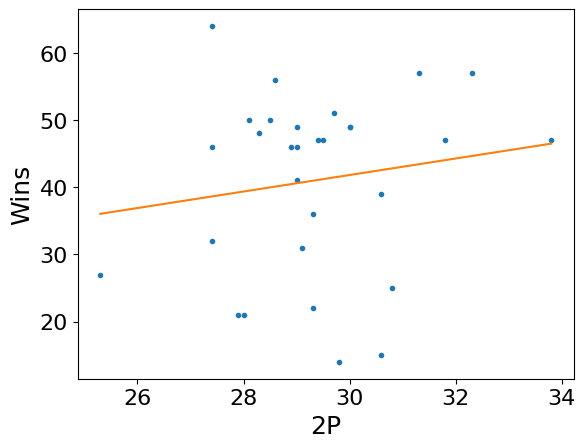

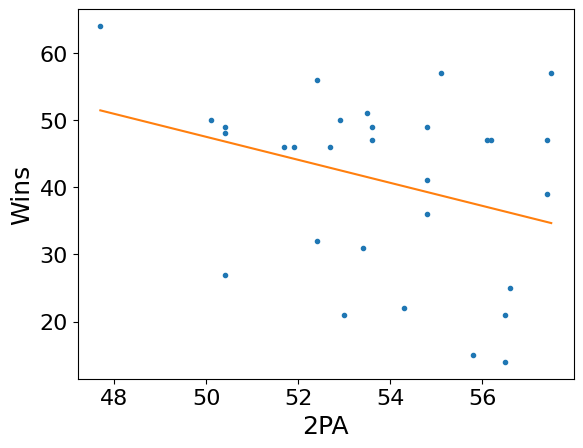

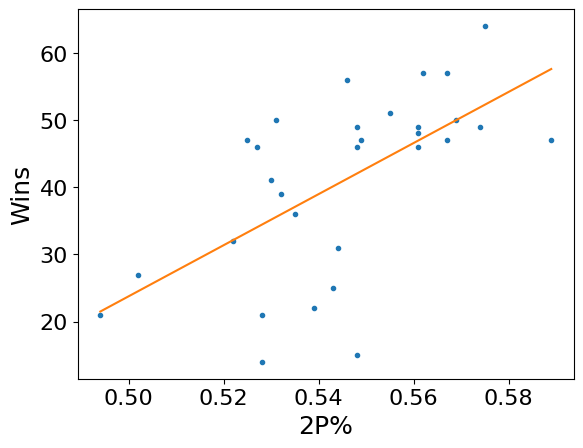

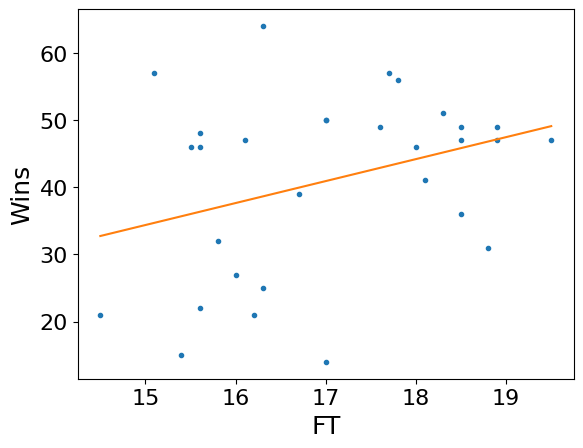

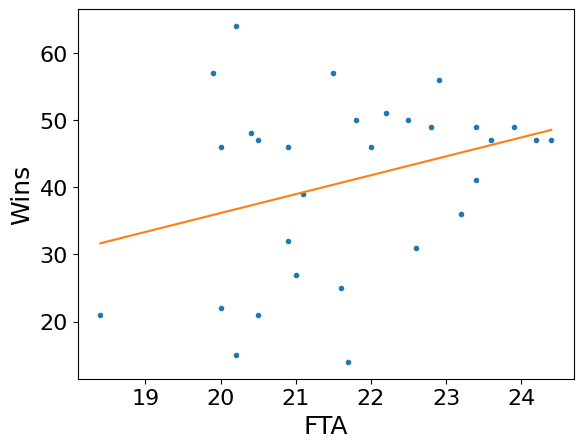

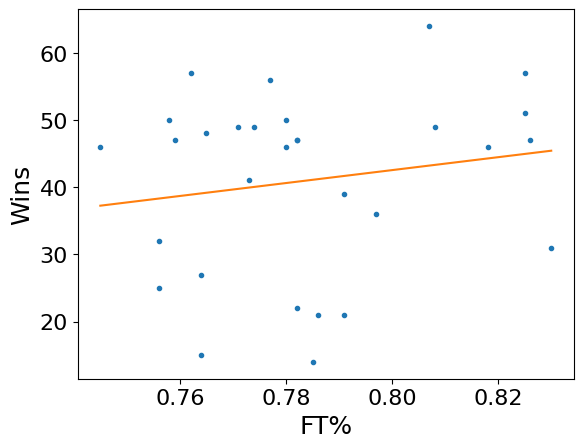

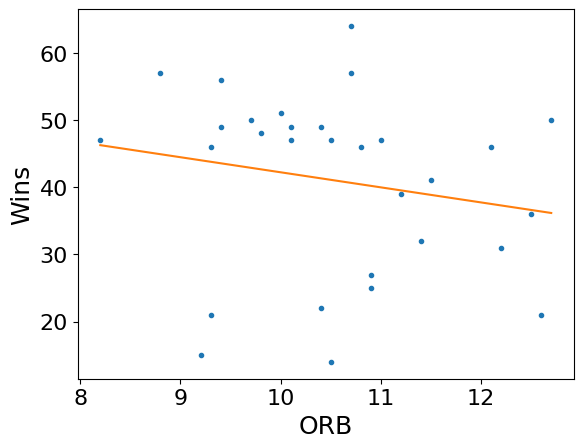

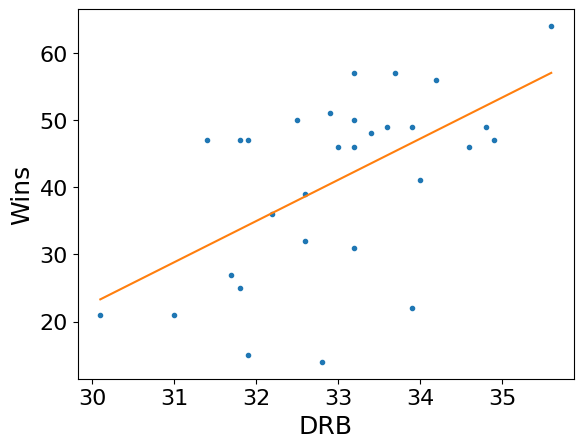

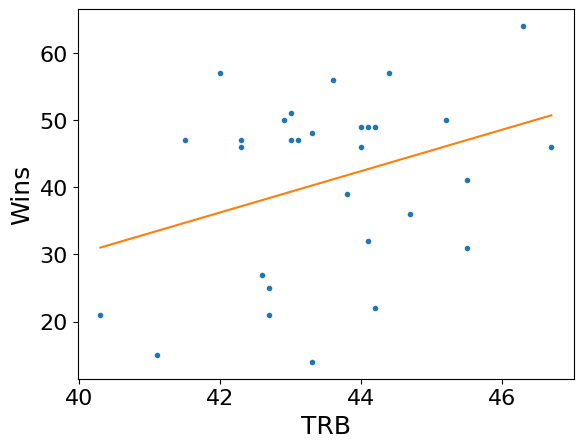

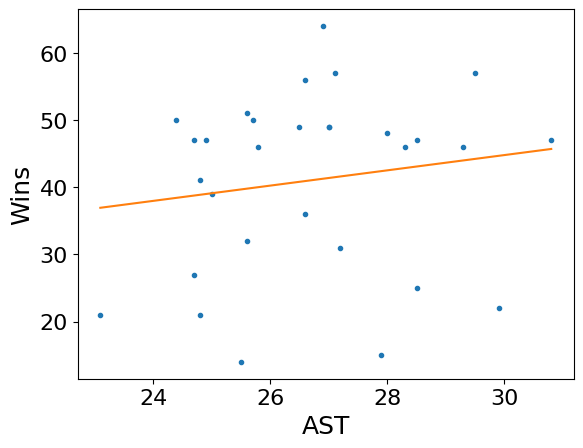

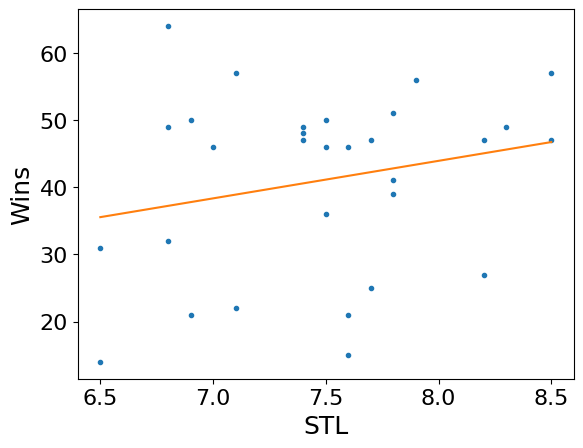

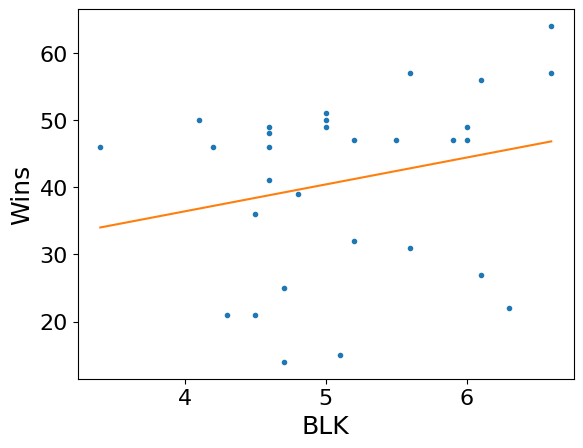

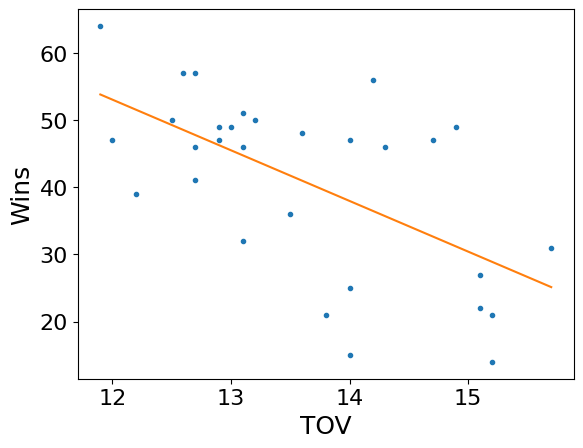

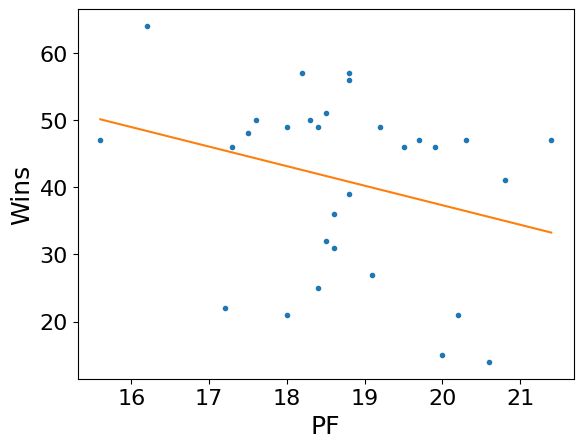

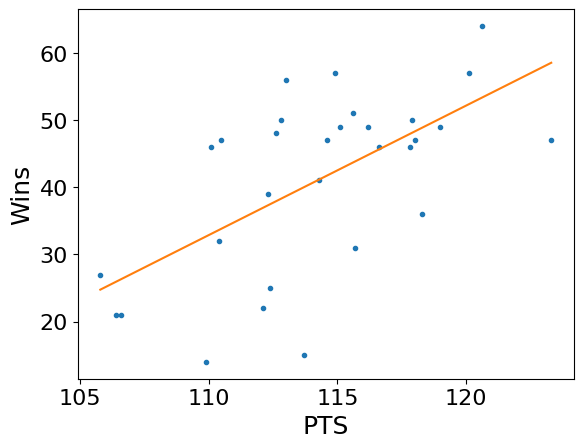

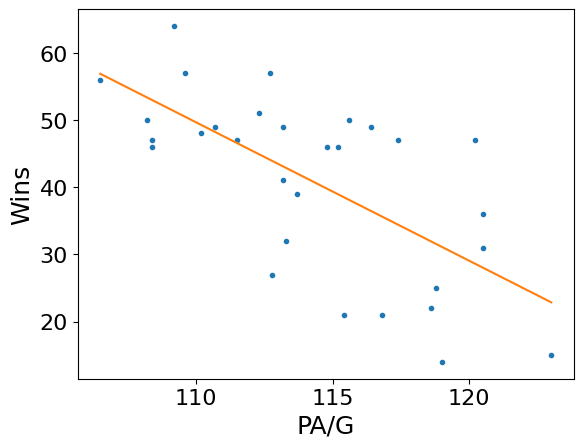

In [19]:
r_list = []

for column in columns_to_test:

    fit = linregress(nba_all[column], nba_all['W'])
    slope = fit.slope
    intercept = fit.intercept
    rvalue = fit.rvalue

    #append the spearman r value to the list we've set up
    r_list.append(rvalue)
    
    x_arr = np.linspace(np.min(nba_all[column]), np.max(nba_all[column]), 100)
    wins_arr = slope * x_arr + intercept

    plt.plot(nba_all[column], nba_all['W'], '.')
    plt.plot(x_arr, wins_arr)
    plt.xlabel(column)
    plt.ylabel('Wins')
    plt.show()

#make r_list an array so it's easier to manipulate
r_list = np.array(r_list)

Now, let's take a look what our new r_list variable looks like.

In [20]:
r_list

array([ 0.46439995, -0.22542904,  0.68537025,  0.44494048,  0.11969535,
        0.85585003,  0.15318454, -0.32016622,  0.60956901,  0.33378295,
        0.3153773 ,  0.17008937, -0.1928421 ,  0.56674917,  0.33471841,
        0.15720594,  0.23116223,  0.23715685, -0.59647622, -0.28364718,
        0.61208934, -0.6620007 ])

So r_list is an array of all of the spearman r values that measured. This Now, we want to find out which variable has the strongest positive correlation. Let's take a look at the length of the array.

In [21]:
len(r_list)

22

And now let's take a look at the length of the columns that we looped through:

In [22]:
len(columns_to_test), columns_to_test

(22,
 ['FG',
  'FGA',
  'FG%',
  '3P',
  '3PA',
  '3P%',
  '2P',
  '2PA',
  '2P%',
  'FT',
  'FTA',
  'FT%',
  'ORB',
  'DRB',
  'TRB',
  'AST',
  'STL',
  'BLK',
  'TOV',
  'PF',
  'PTS',
  'PA/G'])

These have the same length, and they should, because we saved one value of r for every column that we tested. So every value in the r_list corresponds to the r value for the variable that is at the same index position in the columns_to_test list. So if we want to find the variable that is the most strongly correlated with wins, what we want to do is look for the maximum value in r_list. Let's see what that maximum is.

In [23]:
np.max(r_list)

0.855850030387598

Now we know that there is something in there that is strongly correlated with wins, and we want to find out what it is. To do this, we need to find the "argmax" of that variable--the index of the list that corresponds to the maximum value. We can do that with the np.argmax function.

In [24]:
np.argmax(r_list)

5

In [25]:
r_list[5]

0.855850030387598

What that tells us is that the "5th" element of the list corresponds to the highest value. Because of the way arrays and lists work in python, we can easily see what that value is like so:

In [26]:
columns_to_test[np.argmax(r_list)]

'3P%'

Interesting! So we can actually see that the stat that is the most strongly correlated with winning isn't points/game, it's actually 3 point percentage! Let's take a look again at that correlation:

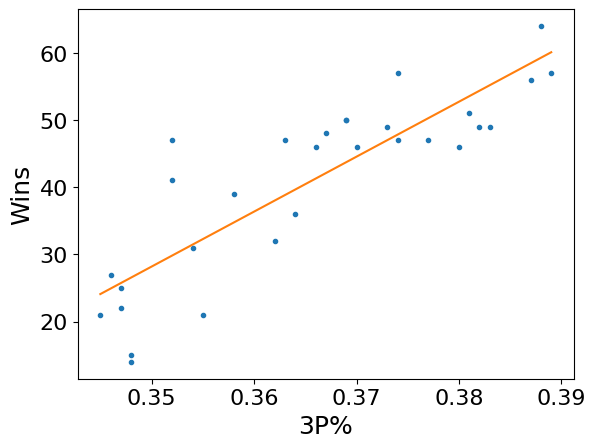

In [27]:
column_max = columns_to_test[np.argmax(r_list)]

fit = linregress(nba_all[column_max], nba_all['W'])
slope = fit.slope
intercept = fit.intercept
rvalue = fit.rvalue

x_arr = np.linspace(np.min(nba_all[column_max]), np.max(nba_all[column_max]), 100)
wins_arr = slope * x_arr + intercept

plt.plot(nba_all[column_max], nba_all['W'], '.')
plt.plot(x_arr, wins_arr)
plt.xlabel(column_max)
plt.ylabel('Wins')
plt.show()

It's interesting to see that even though there's only a small range in the total percentages teams shoot (the worst teams shoot 34%, the best teams shoot 39%), the correlation is so strong. Let's take a look at the slope and interpret it. How can we interpret this number?

In [28]:
slope

817.9430305860374

The slope has units of "wins per 3P%", so if we want to know how many wins shooting 1% better at the 3 point line corresponds to, we can multiply our slope by the value we want to see. Let's check to see how much of an increase in wins 1% at the free throw line corresponds to:

In [31]:
0.03 * slope

24.53829091758112

So shooting 1% better at the line corresponds to winning 8 more games in a season! That's a huge increase for what seems like such a small number, but when you're shooting 30-40 three point shots every game, that 1% difference corresponds to a lot of points on average!

# Activity: find out what the strongest *negative* correlation in the catalog is. Also, find out which statistic is the the least correlation with wins (so closest to no effect).

After you find these, plot the relations.

- Hint: the opposite of "argmax" is "argmin"

- Hint: to find the least correlated variable, you want to find to find the value that is the closest to 0, regardless of sign. There are a few ways that you can do this, but one way is to think about the statistic we measured that is very closely related to the rvalue as well.

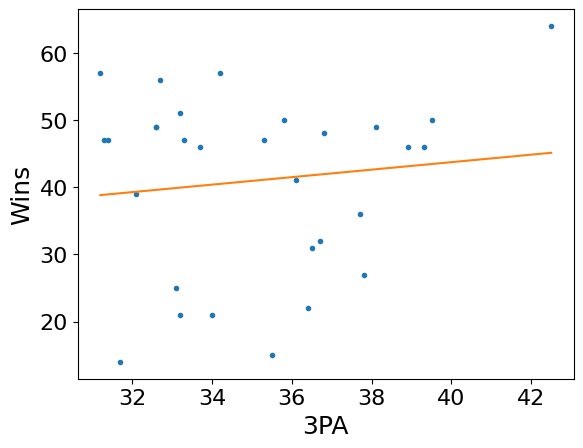

In [38]:
rsquare_list = r_list**2

column_min = columns_to_test[np.argmin(rsquare_list)]

fit = linregress(nba_all[column_min], nba_all['W'])
slope = fit.slope
intercept = fit.intercept
rvalue = fit.rvalue

x_arr = np.linspace(np.min(nba_all[column_min]), np.max(nba_all[column_min]), 100)
wins_arr = slope * x_arr + intercept

plt.plot(nba_all[column_min], nba_all['W'], '.')
plt.plot(x_arr, wins_arr)
plt.xlabel(column_min)
plt.ylabel('Wins')
plt.show()

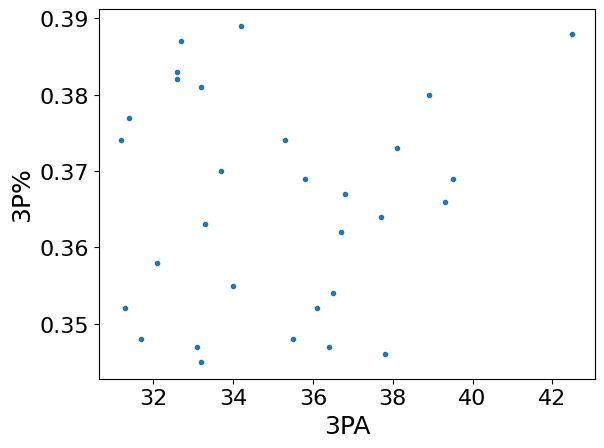

In [39]:
plt.plot(nba_all['3PA'], nba_all['3P%'], '.')
plt.xlabel('3PA')
plt.ylabel('3P%')
plt.show()

# Some other activities if you have time:

- Which team had the largest "point differential" (points/game - points against/game). Is this the same team that had the most wins? Is this new stat more strongly correlated with wins than 3 point percentage?

- How do "volume" stats like the number of 3 points attempted correlated with the 3 point percentage? Is that correlation the same as for 2 point shots? What about the number of total shot attempts?

- There are two other data files in here for the 2003-2004 season instead of the 2023-2024 season. Was 3 point percentage still the most correlated stat with wins back then?

Text(0.5, 0, 'Points/Game - Points Against/Game')

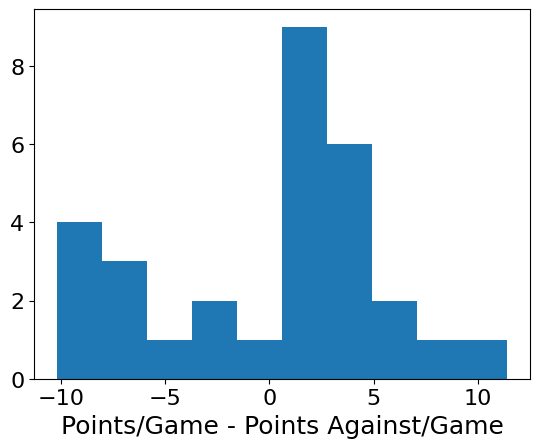

In [44]:
nba_all['pt_diff'] = nba_all['PS/G'] - nba_all['PA/G']

plt.hist(nba_all['pt_diff'])
plt.xlabel('Points/Game - Points Against/Game')

Text(0, 0.5, 'Wins')

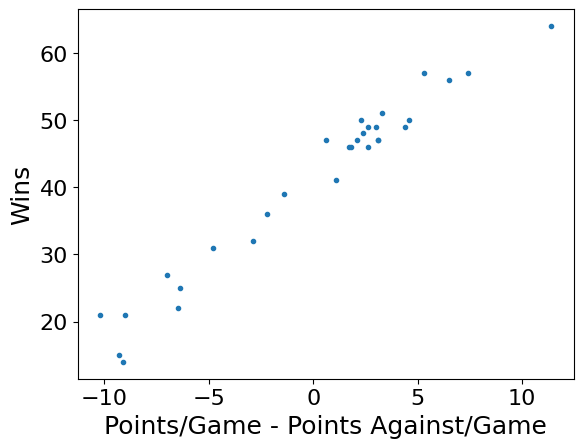

In [45]:
plt.plot(nba_all['pt_diff'], nba_all['W'], '.')
plt.xlabel('Points/Game - Points Against/Game')
plt.ylabel('Wins')

In [47]:
fit = linregress(nba_all['pt_diff'], nba_all['W'])
fit

LinregressResult(slope=2.3678763318374494, intercept=40.96053539446938, rvalue=0.9814844124442255, pvalue=1.2174336832192669e-21, stderr=0.08732943961797122, intercept_stderr=0.47730418989599316)

In [50]:
nba_team_stats_old = pd.read_csv('2003-2004_nba_team_stats_per_game.csv')
nba_season_stats_old = pd.read_csv('2003-2004_season_stats.csv')

nba_old = pd.merge(nba_team_stats_old, nba_season_stats_old, on='Team')

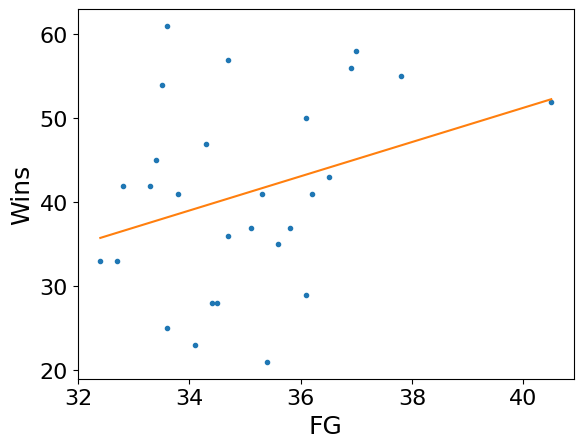

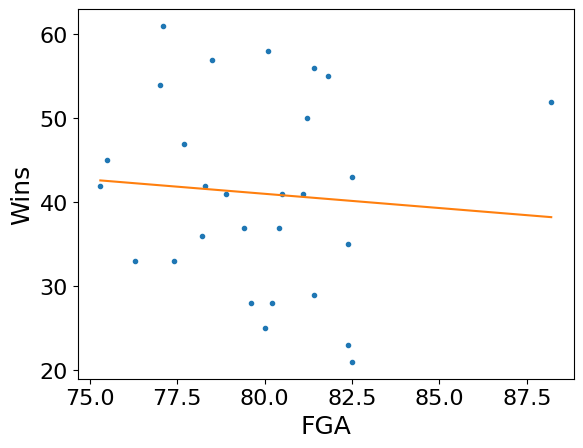

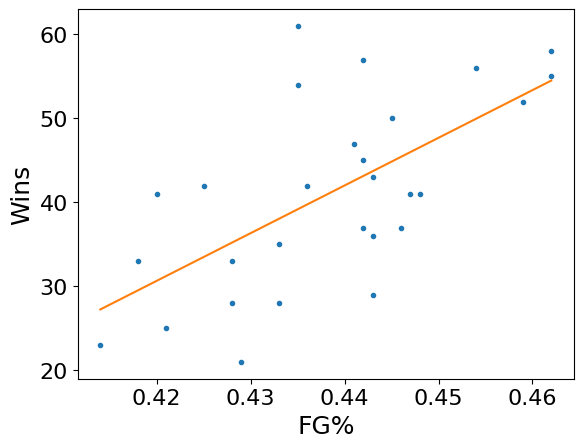

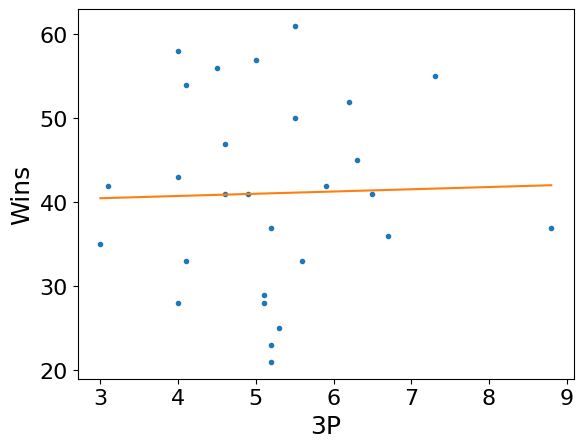

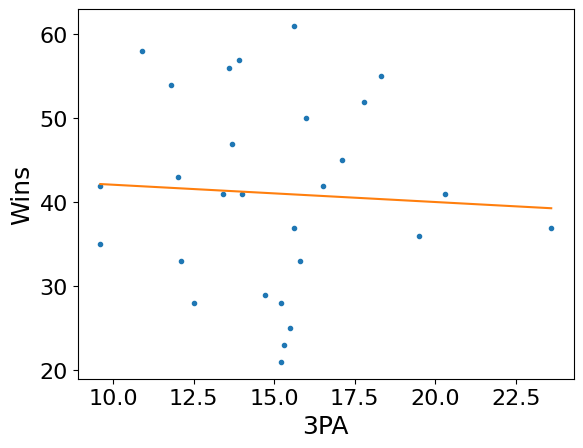

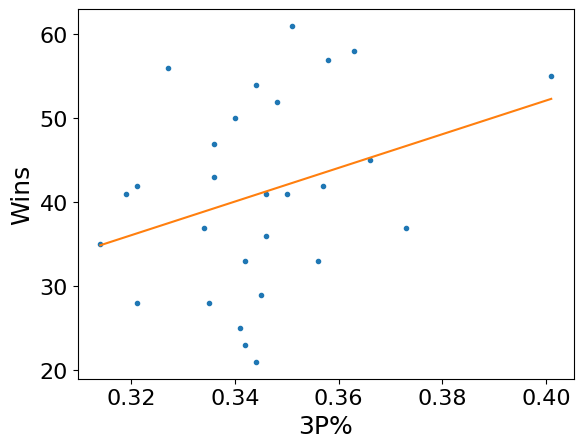

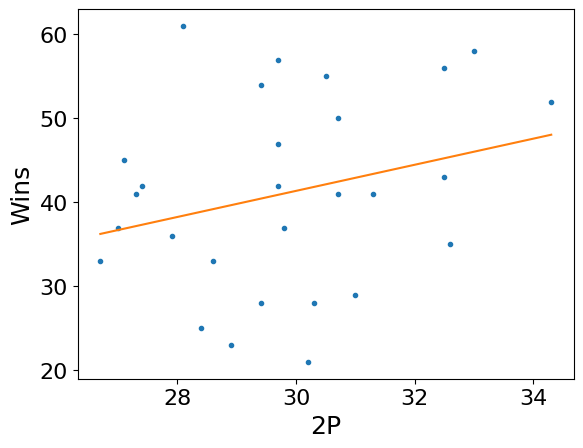

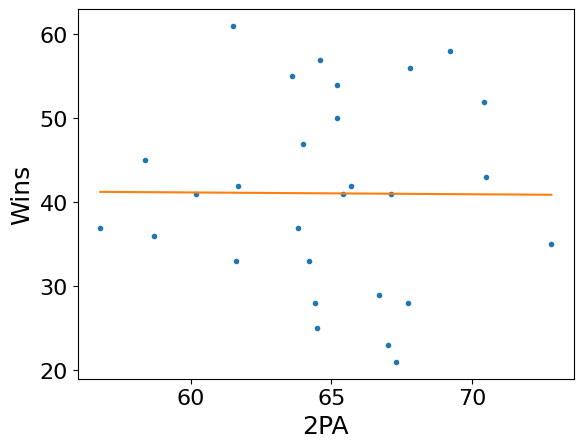

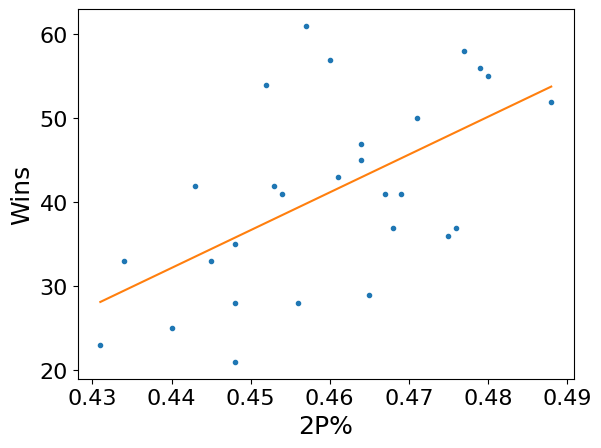

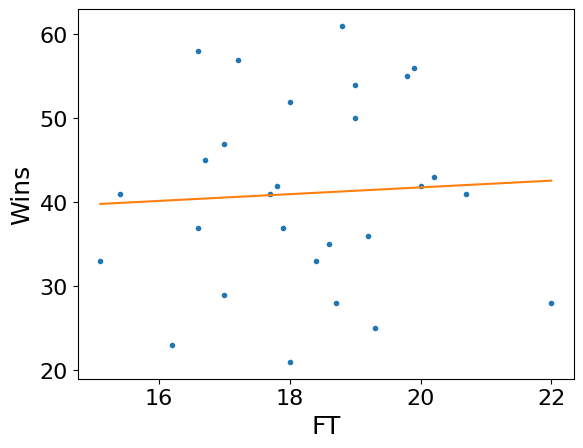

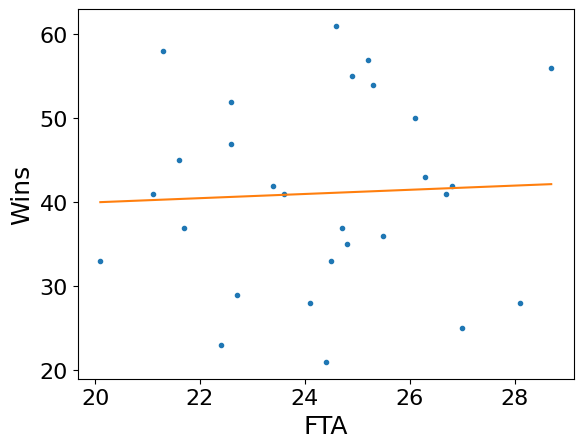

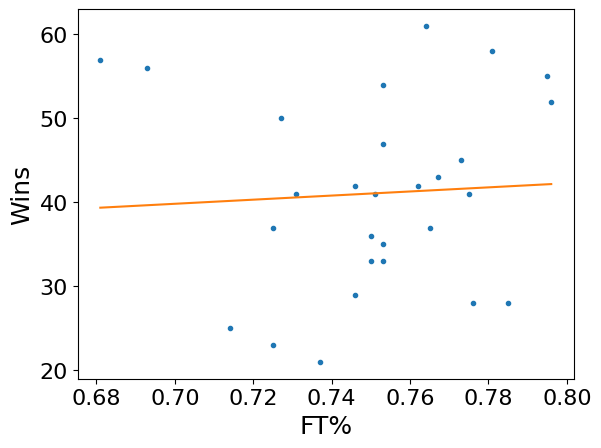

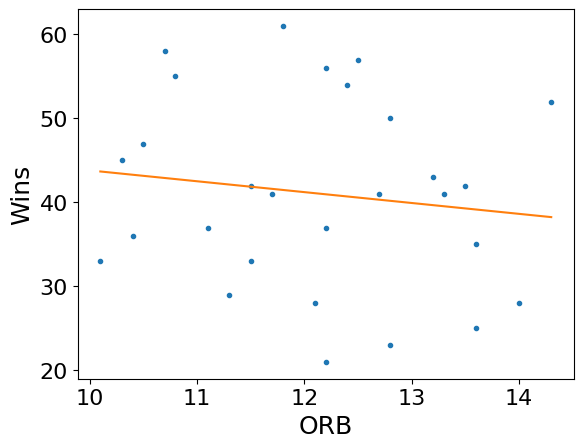

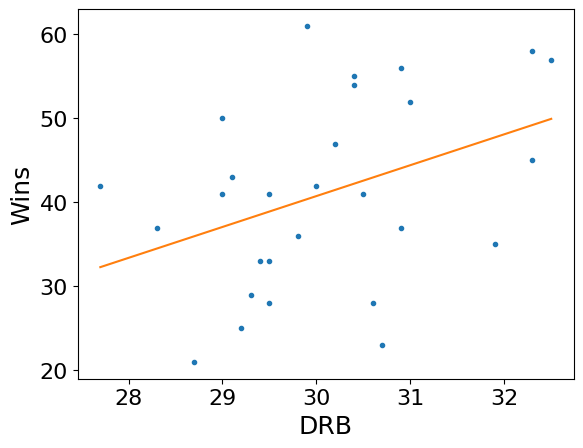

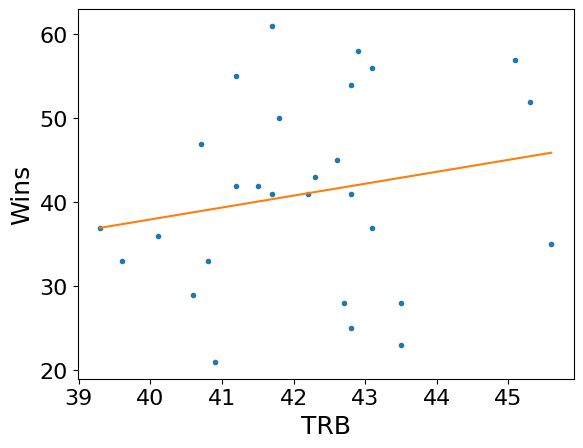

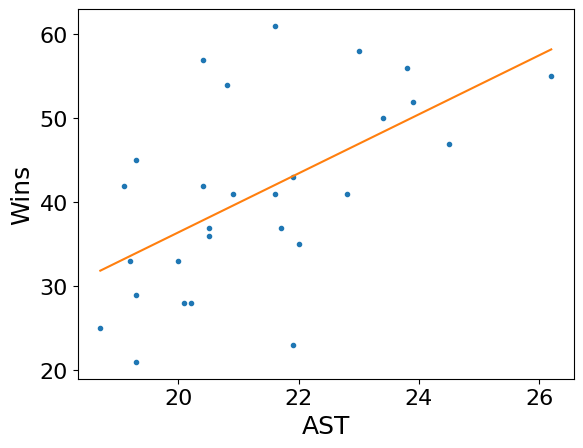

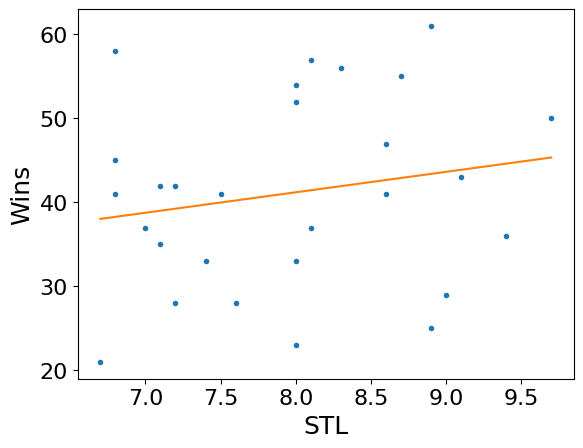

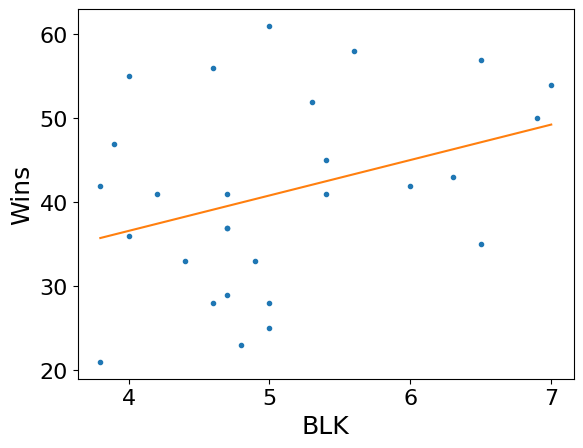

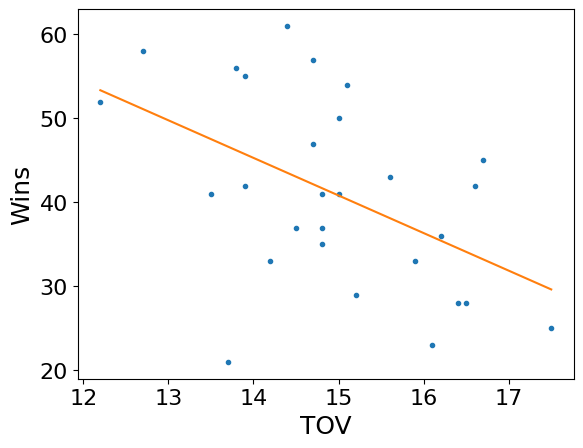

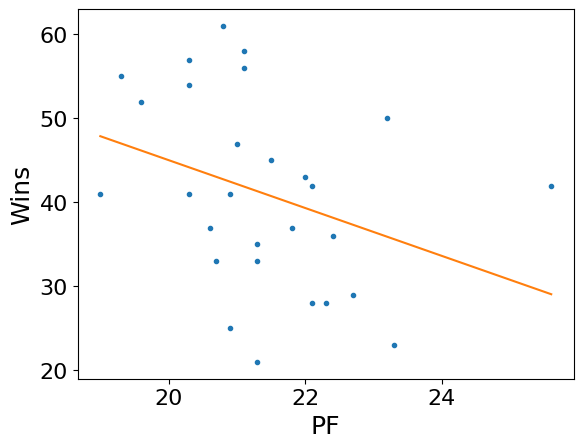

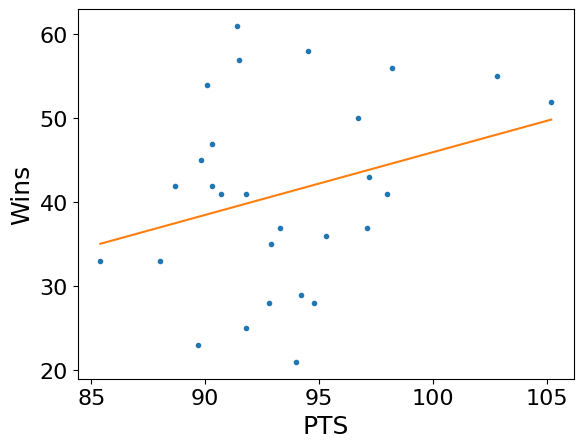

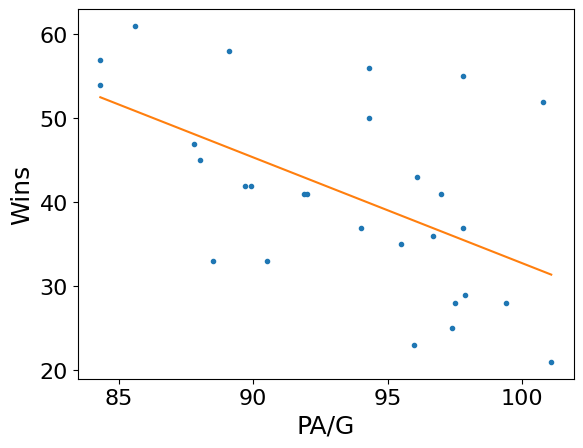

In [51]:
columns_to_test = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
                   '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
                   'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PA/G']

r_list = []

for column in columns_to_test:

    fit = linregress(nba_old[column], nba_old['W'])
    slope = fit.slope
    intercept = fit.intercept
    rvalue = fit.rvalue

    #append the spearman r value to the list we've set up
    r_list.append(rvalue)
    
    x_arr = np.linspace(np.min(nba_old[column]), np.max(nba_old[column]), 100)
    wins_arr = slope * x_arr + intercept

    plt.plot(nba_old[column], nba_old['W'], '.')
    plt.plot(x_arr, wins_arr)
    plt.xlabel(column)
    plt.ylabel('Wins')
    plt.show()

#make r_list an array so it's easier to manipulate
r_list = np.array(r_list)

In [52]:
columns_to_test[np.argmax(r_list)]

'FG%'

In [55]:
np.min(nba_old['3PA']), np.max(nba_all['3PA'])

(9.6, 42.5)

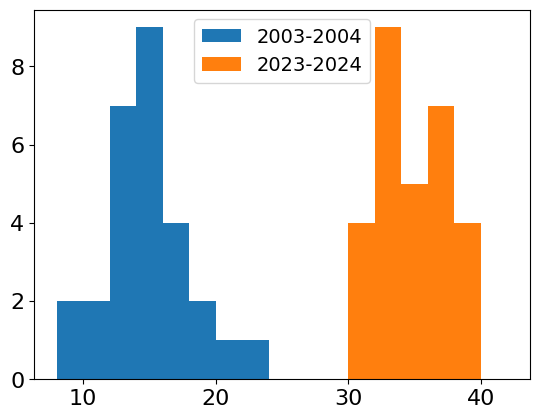

In [56]:
bins = np.arange(8, 44, 2)

plt.hist(nba_old['3PA'], bins=bins, label='2003-2004')
plt.hist(nba_all['3PA'], bins=bins, label='2023-2024')
plt.legend(fontsize=14)
plt.show()